![](https://storage.googleapis.com/kaggle-competitions/kaggle/16592/logos/header.png?t=2019-10-11-15-29-19)

# Loan Default Prediction
### Geekbrains AI/BigData Loan Default Prediction Competition

Your task in this competition is to predict if a person will default on a loan in the test.csv dataset. You will be given two datasets: train.csv (contains the features and Credit Default as a target) and test.csv (features only).

In [1]:
# 1 - import the necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

In [2]:
# 2 - loading training data
train = pd.read_csv('E:\GitHub репозитории\Kaggle-Championships\Kapturov - Geekbrains Loan Default Prediction Competition\\train.csv')
train.head(3)

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [3]:
# 3 - display a list of features
train.columns.tolist()

['Id',
 'Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [4]:
# 4 - see dataset size
train.shape

(7500, 18)

In [5]:
# 5 - check the number of gaps for each feature
train.isna().sum()

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [6]:
# 6 - find out what proportion are missing values
train.isna().sum() / train.shape[0]

Id                              0.000000
Home Ownership                  0.000000
Annual Income                   0.207600
Years in current job            0.049467
Tax Liens                       0.000000
Number of Open Accounts         0.000000
Years of Credit History         0.000000
Maximum Open Credit             0.000000
Number of Credit Problems       0.000000
Months since last delinquent    0.544133
Bankruptcies                    0.001867
Purpose                         0.000000
Term                            0.000000
Current Loan Amount             0.000000
Current Credit Balance          0.000000
Monthly Debt                    0.000000
Credit Score                    0.207600
Credit Default                  0.000000
dtype: float64

In [7]:
# 7 - build a heat map of correlations (sns.heatmap produced anomalous errors)
correlation = train.corr()
correlation.style.background_gradient(cmap='coolwarm')

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Id,1.000000,0.011426,0.003393,0.004145,-0.009556,-0.022672,0.008264,0.007262,0.003183,-0.008485,-0.015758,0.005590,0.036498,0.012858
Annual Income,0.011426,1.000000,0.066245,0.188524,0.186531,0.062218,-0.015407,-0.101787,-0.066877,0.032082,0.386481,0.584819,-0.037832,-0.101375
Tax Liens,0.003393,0.066245,1.000000,-0.005360,0.009109,-0.002410,0.595339,0.052446,0.057360,-0.007835,-0.010195,0.027211,0.010581,0.024368
Number of Open Accounts,0.004145,0.188524,-0.005360,1.000000,0.144819,0.023897,-0.017813,-0.032740,-0.019130,0.001346,0.267325,0.413904,0.016095,0.028884
Years of Credit History,-0.009556,0.186531,0.009109,0.144819,1.000000,0.029247,0.071259,-0.015375,0.085699,0.010623,0.217856,0.191978,-0.015683,-0.020567
Maximum Open Credit,-0.022672,0.062218,-0.002410,0.023897,0.029247,1.000000,-0.004750,-0.003849,-0.011650,-0.002334,0.088090,0.010197,-0.009136,-0.014275
Number of Credit Problems,0.008264,-0.015407,0.595339,-0.017813,0.071259,-0.004750,1.000000,0.139905,0.730751,-0.008596,-0.124137,-0.042252,-0.018473,0.020088
Months since last delinquent,0.007262,-0.101787,0.052446,-0.032740,-0.015375,-0.003849,0.139905,1.000000,0.162710,0.000459,-0.027198,-0.057702,-0.004395,0.002598
Bankruptcies,0.003183,-0.066877,0.057360,-0.019130,0.085699,-0.011650,0.730751,0.162710,1.000000,-0.005987,-0.142849,-0.079579,-0.027488,0.001648
Current Loan Amount,-0.008485,0.032082,-0.007835,0.001346,0.010623,-0.002334,-0.008596,0.000459,-0.005987,1.000000,0.016672,-0.009382,-0.108552,-0.226522


The columns **Bankruptcies** and **Number of Credit Problems** are highly correlated (0.73) so one of them needs to be removed to avoid the multicollinearity problem. Because **Number of Credit Problems** has a significant correlation with the feature **Tax Liens**, then we will remove it from train, and hence from test

In [8]:
# 8 - remove column Number of Credit Problems
train.drop('Number of Credit Problems', axis=1, inplace=True)

In [9]:
# 9 - again we will build a heat map of correlations to make sure that now there are no strongly correlated features greater than 0.7
correlation = train.corr()
correlation.style.background_gradient(cmap='coolwarm')

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Id,1.000000,0.011426,0.003393,0.004145,-0.009556,-0.022672,0.007262,0.003183,-0.008485,-0.015758,0.005590,0.036498,0.012858
Annual Income,0.011426,1.000000,0.066245,0.188524,0.186531,0.062218,-0.101787,-0.066877,0.032082,0.386481,0.584819,-0.037832,-0.101375
Tax Liens,0.003393,0.066245,1.000000,-0.005360,0.009109,-0.002410,0.052446,0.057360,-0.007835,-0.010195,0.027211,0.010581,0.024368
Number of Open Accounts,0.004145,0.188524,-0.005360,1.000000,0.144819,0.023897,-0.032740,-0.019130,0.001346,0.267325,0.413904,0.016095,0.028884
Years of Credit History,-0.009556,0.186531,0.009109,0.144819,1.000000,0.029247,-0.015375,0.085699,0.010623,0.217856,0.191978,-0.015683,-0.020567
Maximum Open Credit,-0.022672,0.062218,-0.002410,0.023897,0.029247,1.000000,-0.003849,-0.011650,-0.002334,0.088090,0.010197,-0.009136,-0.014275
Months since last delinquent,0.007262,-0.101787,0.052446,-0.032740,-0.015375,-0.003849,1.000000,0.162710,0.000459,-0.027198,-0.057702,-0.004395,0.002598
Bankruptcies,0.003183,-0.066877,0.057360,-0.019130,0.085699,-0.011650,0.162710,1.000000,-0.005987,-0.142849,-0.079579,-0.027488,0.001648
Current Loan Amount,-0.008485,0.032082,-0.007835,0.001346,0.010623,-0.002334,0.000459,-0.005987,1.000000,0.016672,-0.009382,-0.108552,-0.226522
Current Credit Balance,-0.015758,0.386481,-0.010195,0.267325,0.217856,0.088090,-0.027198,-0.142849,0.016672,1.000000,0.504964,-0.006159,-0.019522


The columns **Monthly Debt** and **Annual Income** are highly correlated (0.73) so one of them needs to be removed to avoid the multicollinearity problem. Because **Monthly Debt** has a significant correlation with the feature **Current Credit Balance**, then we will remove it from train, and hence from test

In [10]:
# 10 - remove column Number of Credit Problems
train.drop('Monthly Debt', axis=1, inplace=True)

In [11]:
# 11 - once again we will build a heat map of correlations to make sure that now there are no strongly correlated features greater than 0.7
correlation = train.corr()
correlation.style.background_gradient(cmap='coolwarm')

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Credit Score,Credit Default
Id,1.000000,0.011426,0.003393,0.004145,-0.009556,-0.022672,0.007262,0.003183,-0.008485,-0.015758,0.036498,0.012858
Annual Income,0.011426,1.000000,0.066245,0.188524,0.186531,0.062218,-0.101787,-0.066877,0.032082,0.386481,-0.037832,-0.101375
Tax Liens,0.003393,0.066245,1.000000,-0.005360,0.009109,-0.002410,0.052446,0.057360,-0.007835,-0.010195,0.010581,0.024368
Number of Open Accounts,0.004145,0.188524,-0.005360,1.000000,0.144819,0.023897,-0.032740,-0.019130,0.001346,0.267325,0.016095,0.028884
Years of Credit History,-0.009556,0.186531,0.009109,0.144819,1.000000,0.029247,-0.015375,0.085699,0.010623,0.217856,-0.015683,-0.020567
Maximum Open Credit,-0.022672,0.062218,-0.002410,0.023897,0.029247,1.000000,-0.003849,-0.011650,-0.002334,0.088090,-0.009136,-0.014275
Months since last delinquent,0.007262,-0.101787,0.052446,-0.032740,-0.015375,-0.003849,1.000000,0.162710,0.000459,-0.027198,-0.004395,0.002598
Bankruptcies,0.003183,-0.066877,0.057360,-0.019130,0.085699,-0.011650,0.162710,1.000000,-0.005987,-0.142849,-0.027488,0.001648
Current Loan Amount,-0.008485,0.032082,-0.007835,0.001346,0.010623,-0.002334,0.000459,-0.005987,1.000000,0.016672,-0.108552,-0.226522
Current Credit Balance,-0.015758,0.386481,-0.010195,0.267325,0.217856,0.088090,-0.027198,-0.142849,0.016672,1.000000,-0.006159,-0.019522


### There is no any more strong correlations!

In [12]:
# 12 - set up visualization
sns.set(rc={'figure.figsize': (12, 8)})

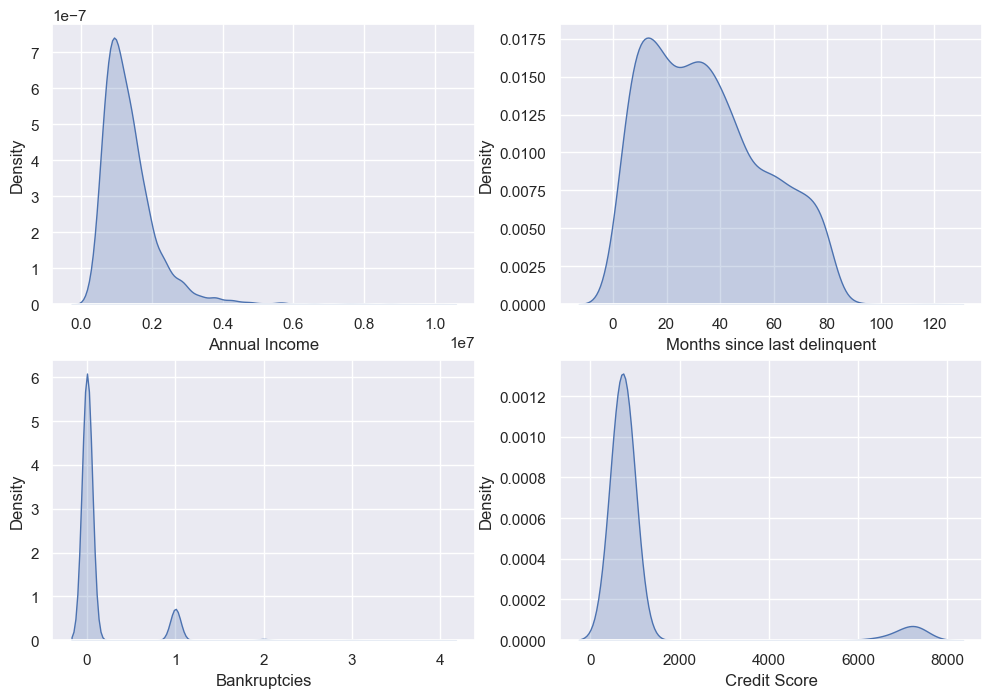

In [13]:
# 13 - let's look at the distributions of features that have gaps and type float64/int
plt.subplot(2, 2, 1)
sns.kdeplot(data=train['Annual Income'], fill=True)

plt.subplot(2, 2, 2)
sns.kdeplot(data=train['Months since last delinquent'], fill=True);

plt.subplot(2, 2, 3)
sns.kdeplot(data=train['Bankruptcies'], fill=True);

plt.subplot(2, 2, 4)
sns.kdeplot(data=train['Credit Score'], fill=True);

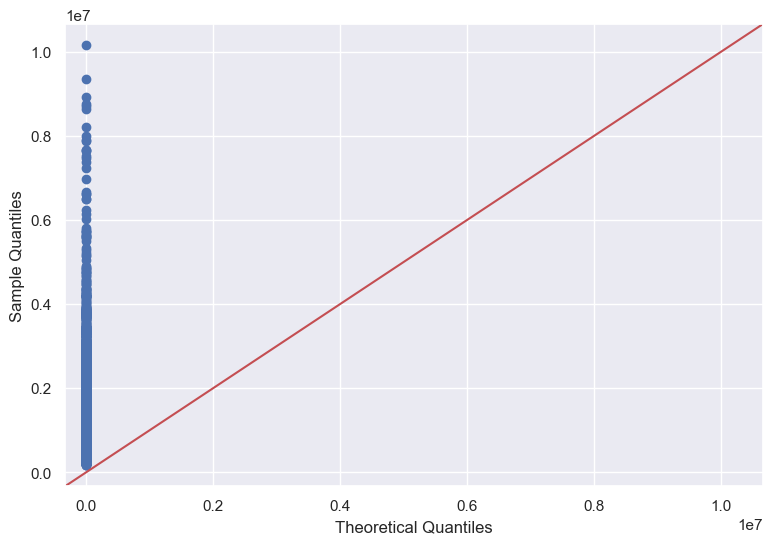

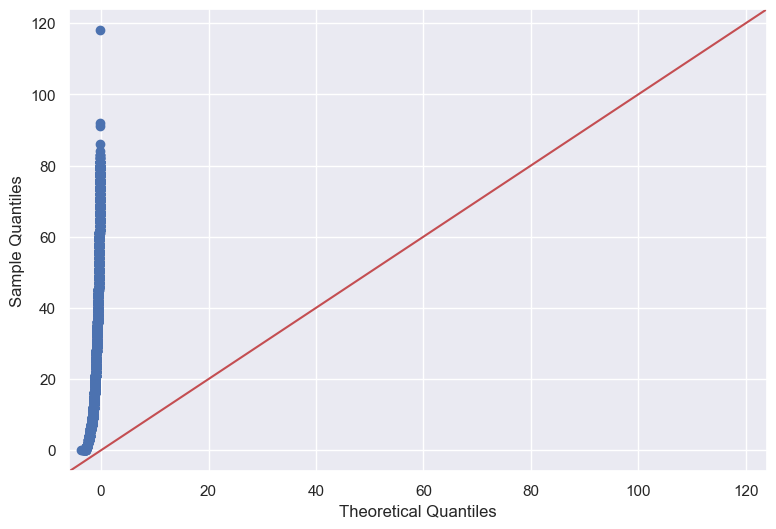

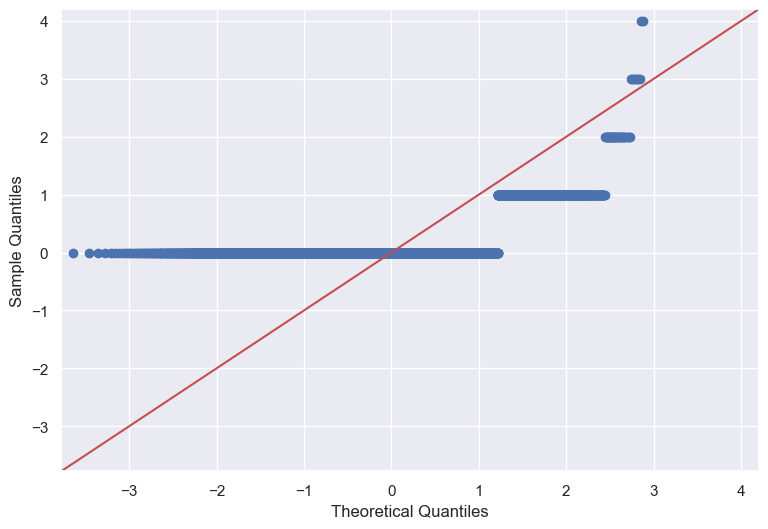

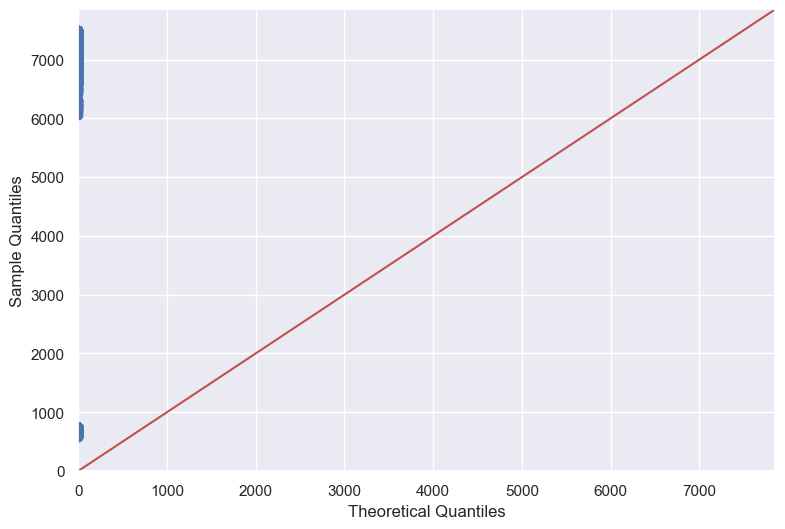

In [14]:
# 14 - using qq-plot, check the normality of the distribution of features that have gaps and type float64
import statsmodels.api as sm

sns.set(rc={'figure.figsize': (9, 6)})
fig = sm.qqplot(train['Annual Income'], line='45')
fig = sm.qqplot(train['Months since last delinquent'], line='45')
fig = sm.qqplot(train['Bankruptcies'], line='45')
fig = sm.qqplot(train['Credit Score'], line='45');

# make sure the distributions are not normal

In [15]:
# 15 - fill in the gaps of features of type float64 with median values, and fill in the gaps "Years in current job" with mods
train['Annual Income'].fillna(train['Annual Income'].median(), inplace=True)
train['Months since last delinquent'].fillna(train['Months since last delinquent'].median(), inplace=True)
train['Bankruptcies'].fillna(train['Bankruptcies'].median(), inplace=True)
train['Credit Score'].fillna(train['Credit Score'].median(), inplace=True)

train['Years in current job'].fillna(train['Annual Income'].mode().iloc[0], inplace=True)

In [16]:
# 16 - check again the number of gaps for each feature of the training dataset
train.isna().sum()

Id                              0
Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Credit Score                    0
Credit Default                  0
dtype: int64

In [17]:
# 17 - split the training dataset into X and y
X = train.drop(['Id', 'Credit Default'], axis=1)
y = train['Credit Default']

In [18]:
# 18 - load test data and remove the ID column
test = pd.read_csv('E:\GitHub репозитории\Kaggle-Championships\Kapturov - Geekbrains Loan Default Prediction Competition\\test.csv')
ID = test.Id
test.drop(['Id', 'Number of Credit Problems', 'Monthly Debt'], axis=1, inplace=True)

In [19]:
# 19 - check for gaps in the test dataset
test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Credit Score                     513
dtype: int64

In [20]:
# 20 - fill in the gaps in the test data in the same way as the training data
test['Annual Income'].fillna(test['Annual Income'].median(), inplace=True)
test['Months since last delinquent'].fillna(test['Months since last delinquent'].median(), inplace=True)
test['Bankruptcies'].fillna(test['Bankruptcies'].median(), inplace=True)
test['Credit Score'].fillna(test['Credit Score'].median(), inplace=True)

test['Years in current job'].fillna(test['Annual Income'].mode().iloc[0], inplace=True)

In [21]:
# 21 - again check the number of gaps for each of the properties of the test dataset
test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Credit Score                    0
dtype: int64

In [22]:
# 22 - Let's do a One-Hot transformation
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [23]:
# 23 - look at the transformed features of the dataset
X.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Credit Score,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Short Term
0,482087.0,0.0,11.0,26.3,685960.0,32.0,1.0,99999999.0,47386.0,749.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,0.0,15.0,15.3,1181730.0,32.0,0.0,264968.0,394972.0,737.0,...,0,0,0,0,0,0,0,0,0,0
2,751412.0,0.0,11.0,35.0,1182434.0,32.0,0.0,99999999.0,308389.0,742.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,0.0,8.0,22.5,147400.0,32.0,1.0,121396.0,95855.0,694.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,0.0,13.0,13.6,385836.0,32.0,0.0,125840.0,93309.0,719.0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
# 24 - display a complete list of new features
X.columns.tolist()

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Credit Score',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_va

In [25]:
# 25 - To avoid the error "X has 40 features, but MinMaxScaler is expecting 41 features as input.",
# remove column "Purpose_renewable energy" having 2 occurrences in train and none in test
X = X.drop('Purpose_renewable energy', axis=1)

In [26]:
# 26 - normalize the data
sc = MinMaxScaler()
train_std = sc.fit_transform(X)  # first we train
test_std = sc.transform(test)

### Обучим 4 разные модели - логистическую регрессию, классификатор решающих деревьев, классифиатор случайного леса и классификатор k-ближайших соседей

In [27]:
# 27 - train a logistic regression model and look at the metrics
clf_log_reg = LogisticRegression().fit(train_std, y)
y_pred = clf_log_reg.predict(train_std)
y_proba = clf_log_reg.predict_proba(train_std)

print(f'ROC-AUC = {round(roc_auc_score(y, y_proba[:, 1]), 4)}\n')
print(classification_report(y, y_pred))

ROC-AUC = 0.7614

              precision    recall  f1-score   support

           0       0.77      0.99      0.86      5387
           1       0.87      0.23      0.37      2113

    accuracy                           0.77      7500
   macro avg       0.82      0.61      0.61      7500
weighted avg       0.80      0.77      0.72      7500



In [28]:
# 28 - train a decision tree model and look at the metrics
clf_dec_tree = DecisionTreeClassifier(max_depth=5).fit(train_std, y)
y_pred = clf_dec_tree.predict(train_std)
y_proba = clf_dec_tree.predict_proba(train_std)

print(f'ROC-AUC = {round(roc_auc_score(y, y_proba[:, 1]), 4)}\n')
print(classification_report(y, y_pred))

ROC-AUC = 0.7563

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      5387
           1       0.67      0.40      0.50      2113

    accuracy                           0.77      7500
   macro avg       0.73      0.66      0.68      7500
weighted avg       0.76      0.77      0.75      7500



In [29]:
# 29 - train the k-nearest neighbors model and look at the metrics
warnings.filterwarnings('ignore')

clf_k_neigg = KNeighborsClassifier().fit(train_std, y)
y_pred = clf_k_neigg.predict(train_std)
y_proba = clf_k_neigg.predict_proba(train_std)

print(f'ROC-AUC = {round(roc_auc_score(y, y_proba[:, 1]), 4)}\n')
print(classification_report(y, y_pred))

ROC-AUC = 0.8571

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      5387
           1       0.76      0.47      0.58      2113

    accuracy                           0.81      7500
   macro avg       0.79      0.71      0.73      7500
weighted avg       0.80      0.81      0.79      7500



In [30]:
# 30 - train a random forest model and look at the metrics
clf_rand_for = RandomForestClassifier(max_depth=5).fit(train_std, y)
y_pred = clf_rand_for.predict(train_std)
y_proba = clf_rand_for.predict_proba(train_std)

print(f'ROC-AUC = {round(roc_auc_score(y, y_proba[:, 1]), 4)}\n')
print(classification_report(y, y_pred))

ROC-AUC = 0.7867

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      5387
           1       1.00      0.19      0.32      2113

    accuracy                           0.77      7500
   macro avg       0.88      0.59      0.59      7500
weighted avg       0.83      0.77      0.71      7500



In [31]:
# 31 - make a prediction on the data using a decision tree model
predictions = clf_dec_tree.predict(test_std)
predictions

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [32]:
# 32 - prepare a file for sambit solution
output = pd.DataFrame({'Id': ID})
output['Credit Default'] = predictions
output.head()

,Id,Credit Default
0,7500,0
1,7501,0
2,7502,1
3,7503,0
4,7504,0


In [33]:
# 33 - save file for submission
output.to_csv('geekbrains_loan_default_submission.csv', index=False)

In [34]:
# 34 - let's see how many defaults are expected for the model
output['Credit Default'].value_counts()

0    2072
1     428
Name: Credit Default, dtype: int64